In [3]:
import multi_axis as ma
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from scipy import constants                     # For scientific constants
import matplotlib.patches as patches
import tomopy
%config Completer.use_jedi = False

In [16]:
def generate_phase_data(MX,MY,MZ,angles,mesh_params=None):
    """ Returns phase projections for given M and angles
    in order [x, i_tilt, y] """
    # Initialise parameters
    phase_projs = []
    if mesh_params == None:
        p1 = (0,0,0)
        s = np.shape(MX)
        p2 = (s[0],s[1],s[2])
        n = p2
        mesh_params = [p1,p2,n]
    
    # Loop through projection angles
    for i in range(len(angles)):
        ax,ay,az = angles[i]
        #rotate M
        MXr,MYr,MZr = rotate_magnetisation(MX,MY,MZ,ax,ay,az)
        #calculate phase
        phase = ma.calculate_phase_M_2D(MXr,MYr,MZr,mesh_params=mesh_params)

        phase_projs.append(phase)            
    
#    # Prepare projections for reconstruction
#    raw_data = np.array(M_projs)
#     raw_data = raw_data -  raw_data.min()
#     raw_data = raw_data/raw_data.max()
    phase_projs = np.transpose(phase_projs,axes=[1,0,2]) # reshape so proj is middle column
        
    return np.array(phase_projs)

def rotate_magnetisation(U,V,W,ax=0,ay=0,az=0):
    """ 
    Takes 3D gridded magnetisation values as input
    and returns them after an intrinsic rotation ax,ay,az 
    about the x,y,z axes (given in degrees) 
    (Uses convention of rotating about z, then y, then x)
    """
    # Rotate the gridded locations of M values
    Ub = ma.rotate_bulk(U,ax,ay,az)
    Vb = ma.rotate_bulk(V,ax,ay,az)
    Wb = ma.rotate_bulk(W,ax,ay,az)
    
    shape = np.shape(Ub)
    
    # Convert gridded values to vectors
    coor_flat = grid_to_coor(Ub,Vb,Wb)
    
    # Rotate vectors
    coor_flat_r = rotate_vector(coor_flat,ax,ay,az)
    
    # Convert vectors back to gridded values
    Ur,Vr,Wr = coor_to_grid(coor_flat_r,shape=shape)
    
    # Set small values to 0
    # (In theory the magnitude of M in each cell should be Ms,
    #  so we can set magnitude lower than this to zero -
    #  typically python rounding errors lead to very small values,
    #  which it is useful to exclude here)
    mag_max = (np.max(U)**2+np.max(V)**2+np.max(W)**2)**0.5
    mag = (Ur**2+Vr**2+Wr**2)**.5
#     for M in [Ur,Vr,Wr]:
#         M[abs(M)<1e-5*mag_max] = 0
#         M[mag<.6*mag_max] = 0
    
    return Ur,Vr,Wr

def grid_to_coor(U,V,W):
    """ Convert gridded 3D data (3,n,n,n) into coordinates (n^3, 3) """
    coor_flat = []
    nx = np.shape(U)[0]
    ny = np.shape(U)[1]
    nz = np.shape(U)[2]
    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                x = U[ix,iy,iz]
                y = V[ix,iy,iz]
                z = W[ix,iy,iz]
                coor_flat.append([x,y,z])
                
    return coor_flat

def coor_to_grid(coor_flat,shape=None):
    """ Convert coordinates (n^3, 3) into gridded 3D data (3,n,n,n) """
    if shape == None:
        n = int(np.round(np.shape(coor_flat)[0]**(1/3)))
        shape = (n,n,n)
    nx,ny,nz = shape
    
    x = np.take(coor_flat,0,axis=1)
    y = np.take(coor_flat,1,axis=1)
    z = np.take(coor_flat,2,axis=1)
    U = x.reshape((nx,ny,nz))
    V = y.reshape((nx,ny,nz))
    W = z.reshape((nx,ny,nz))

    return U, V, W

def rotate_vector(coor_flat,ax,ay,az):
    """ Rotates vectors by specified angles ax,ay,az 
    about the x,y,z axes (given in degrees) """
    
    # Get rotation matrix
    mrot = ma.rotation_matrix(ax,ay,az)    

    coor_flat_r = np.zeros_like(coor_flat)
    
    # Apply rotation matrix to each M vector
    for i,M in enumerate(coor_flat):
        coor_flat_r[i] = mrot.dot(M)
    
    return coor_flat_r

<class 'matplotlib.axes._subplots.AxesSubplot'>
[  5.00000000e-08   5.00000000e-08]


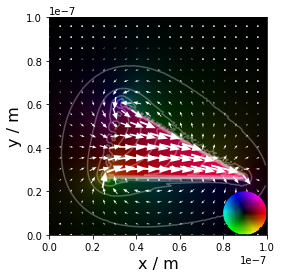

In [15]:
# MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.tri_pris()
# phase = ma.calculate_phase_M_2D(MX,MY,MZ,mesh_params=mesh_params)
# bmag,bx,by = ma.calculate_B_from_phase(phase,mesh_params=mesh_params)
fig,ax=plt.subplots()
ma.plot_2d_B(bx,by,mesh_params=mesh_params,B_contour=True,ax=ax)
ma.plot_colorwheel(clip=1e-8,shape=np.shape(bx)[0]+100,rad=0.1,mesh_params=mesh_params,shift_centre=(80,-80),ax=ax)

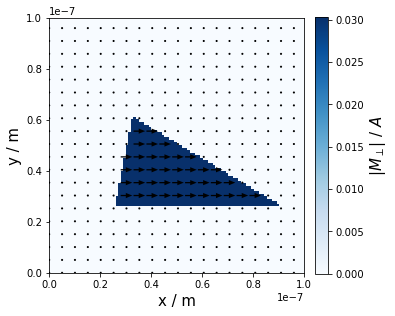

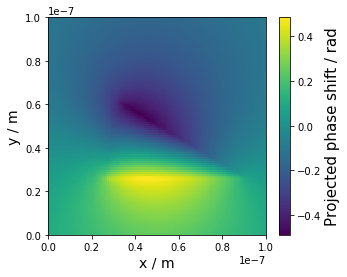

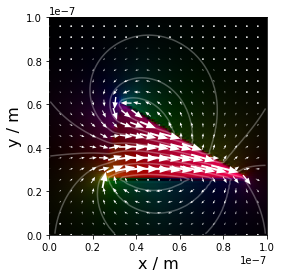

In [3]:
# M
MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.tri_pris()
# phase proj
phase = ma.calculate_phase_M_2D(MX,MY,MZ,mesh_params=mesh_params)
# b proj
bmag,bx,by = ma.calculate_B_from_phase(phase,mesh_params=mesh_params)
# A 3d
AX,AY,AZ,mesh_params2 = ma.calculate_A_3D(MX,MY,MZ,mesh_params=mesh_params,n_pad=100)
# B 3d
BX,BY,BZ = ma.calculate_B_from_A(AX,AY,AZ,mesh_params=mesh_params)

mx,my=ma.project_along_z(MX,mesh_params=mesh_params),ma.project_along_z(MY,mesh_params=mesh_params)
ma.plot_2d_mag(mx,my,mesh_params=mesh_params,s=5)
ma.plot_phase_proj(phase,mesh_params=mesh_params)
ma.plot_2d_B(bx,by,mesh_params=mesh_params,phase=phase,B_contour=False)

In [17]:
# Generate phase projection data
MX,MY,MZ,mesh_params=ma.Magnetic_Phantom.tri_pris()
angles_x = ma.generate_angles(mode='x',n_tilt=13,alpha=90)
angles_y = ma.generate_angles(mode='y',n_tilt=13,beta=90,tilt2='beta')
phases_x = generate_phase_data(MX,MY,MZ,angles_x,mesh_params=mesh_params)
phases_y = generate_phase_data(MX,MY,MZ,angles_y,mesh_params=mesh_params)

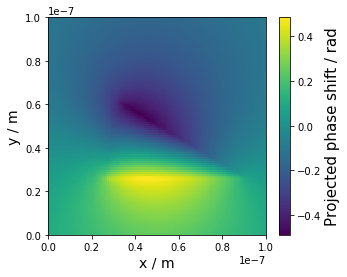

In [114]:
ma.plot_phase_proj(phases_x[:,2,:],mesh_params=mesh_params)

In [18]:
vecs = ma.generate_vectors(angles_x)
recon_x = ma.generate_reconstruction(phases_x,vecs, algorithm = 'SIRT3D_CUDA', niter=20, weight = 0.01,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

vecs = ma.generate_vectors(angles_y)
recon_y = ma.generate_reconstruction(phases_y,vecs, algorithm = 'SIRT3D_CUDA', niter=20, weight = 0.01,
                            balance = 1, steps = 'backtrack', callback_freq = 0)

In [19]:
rx = np.transpose(recon_x,axes=(1,2,0))#[::-1,:,:]
ry = np.transpose(recon_y,axes=(1,2,0))#[::-1,:,:]

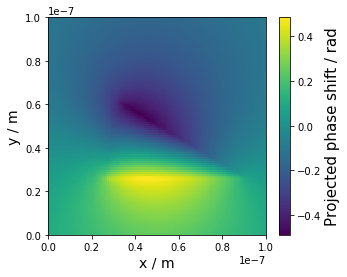

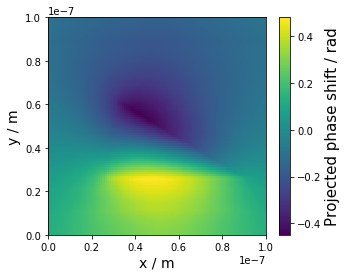

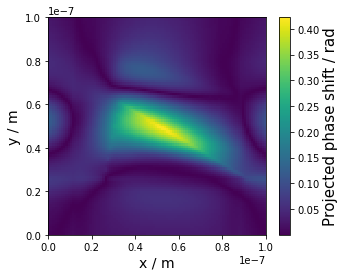

In [20]:
ma.plot_phase_proj(phases_y[:,6,:],mesh_params=mesh_params)
ma.plot_phase_proj(np.sum(ry,axis=2),mesh_params=mesh_params)
ma.plot_phase_proj(np.abs(phases_x[:,2,:]-np.sum(rx,axis=2)),mesh_params=mesh_params)

In [215]:
def calculate_B_dual(PX,PY,mesh_params=None):
    if mesh_params == None:
        p1 = (0,0,0)
        sx,sy = np.shape(mx)
        p2 = (sx,sy,sx)
        n = p2
    else:
        p1,p2,n = mesh_params
        
    x_size = p2[0]
    x_res = x_size/n[0]
    
    y_size = p2[1]
    y_res = y_size/n[1]
    
    BX,BY,BZ = [],[],[]
    
    resx = p2[0]/n[0] # resolution in m per px 
    resy = p2[1]/n[1] # resolution in m per px 
    resz = p2[2]/n[2] # resolution in m per px 
    
    for i in range(np.shape(PX)[2]):
        px = PX[:,:,i]
        py = PY[:,:,i]
        d_phase_x = np.gradient(px,resx)
        d_phase_y = np.gradient(py,resy)
        b_const = (constants.codata.value('mag. flux quantum')/(np.pi))
        b_field_x = -b_const*d_phase_x[0]#/y_res
        b_field_y = b_const*d_phase_y[0]#/x_res
        b_field_z = -1*(np.gradient(b_field_x)[0]+np.gradient(b_field_y)[1])
        
        BX.append(b_field_x)
        BY.append(b_field_y)
        BZ.append(b_field_z)
    
    return np.array(BX),np.array(BY),np.array(BZ)

In [216]:
bx,by,bz = calculate_B_dual(rx,ry,mesh_params=mesh_params)

In [217]:
bxproj, byproj = ma.project_along_z(bx,mesh_params=mesh_params),ma.project_along_z(by,mesh_params=mesh_params)

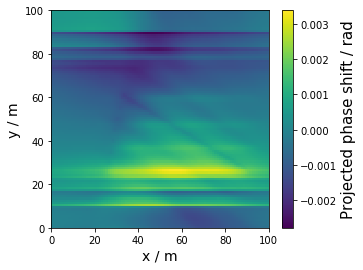

In [44]:
p=ry[:,:,6]#np.sum(ry,2)
ma.plot_phase_proj(p)

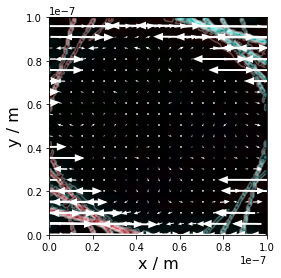

In [233]:
ma.plot_2d_B(bxproj,byproj,mesh_params=mesh_params,scale=1)

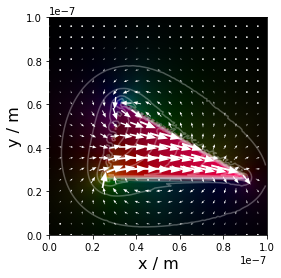

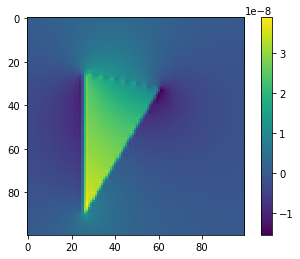

In [223]:
# phase proj
phase = ma.calculate_phase_M_2D(MX,MY,MZ,mesh_params=mesh_params)
# b proj
bmag,bx,by = ma.calculate_B_from_phase(phase,mesh_params=mesh_params)
ma.plot_2d_B(bx,by,mesh_params=mesh_params,s=5)
plt.show()
plt.imshow(bx)
plt.colorbar()

Phantom error:  0.28170539910888814 COD:  0.62033290941


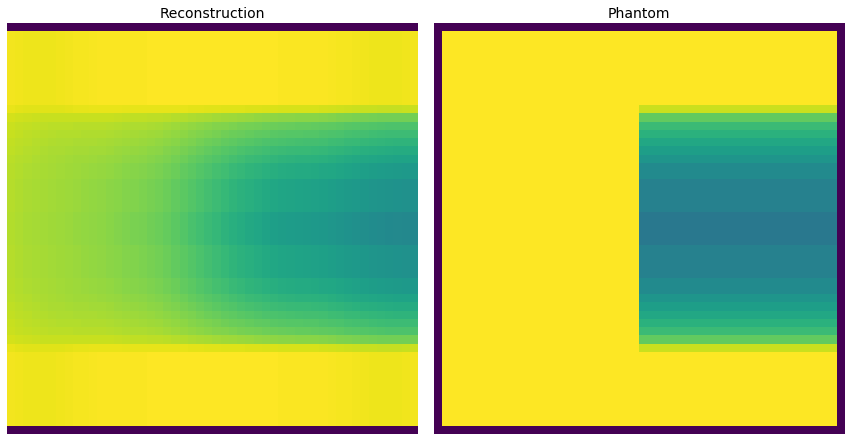

In [73]:
X,Y,Z,P = ma.generate_pillar_cavities(n=50)
angles = ma.generate_angles(mode='y',alpha=90,tilt2='beta')
raw_data = ma.generate_proj_data(P,angles)
vectors = ma.generate_vectors(angles)
recon = ma.generate_reconstruction(raw_data,vectors,algorithm='SIRT3D_CUDA',niter=10,callback_freq=20,weight=0.001)
recon_vector = ma.reorient_reconstruction(recon)
ma.compare_projection(recon_vector,P,ax=90)